In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler

from Bayesian2 import BayesianLinearRegression

sns.set_theme()
sns.set_context("notebook")
%load_ext autoreload
%autoreload 2

In [2]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'BreedName': 'str',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'float',
    'YearSeason': 'str',
    'LactationNumber': 'float',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'FarmHeatStressMilkProduction': 'float'
}

milk_data = pd.read_csv('../Data/MergedData/BLRMilkFarmYieldData.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,NormalizedDailyYield,NormalizedDailyYieldChange,Residuals,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,FarmHeatStressMilkProduction
0,2022-05-28,a624fb9a,SE-064c0cec-1189,3242,02 SLB,8.0,3.0,2022-2,15.22,NaN,...,1.135858,NaN,1.820438,0,0,0,0,9.912500,50.478673,NaN
1,2022-05-29,a624fb9a,SE-064c0cec-1189,3243,02 SLB,8.0,4.0,2022-2,18.96,15.22,...,1.091521,0.215311,1.589745,0,0,0,0,10.066667,53.841648,NaN
2,2022-05-30,a624fb9a,SE-064c0cec-1189,3244,02 SLB,8.0,5.0,2022-2,22.64,18.96,...,1.091326,0.177389,1.894598,0,1,0,0,10.466667,52.935959,NaN
3,2022-05-31,a624fb9a,SE-064c0cec-1189,3245,02 SLB,8.0,6.0,2022-2,26.49,22.64,...,1.121861,0.163049,2.877443,0,0,0,0,11.183333,52.872112,NaN
4,2022-06-01,a624fb9a,SE-064c0cec-1189,3246,02 SLB,8.0,7.0,2022-3,33.61,26.49,...,1.290389,0.273358,7.563598,0,1,0,0,12.704167,56.056547,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
576066,2024-08-09,f454e660,SE-f454e660-810,1020,99 Korsning/obestämbar ras,1.0,365.0,2024-3,37.53,31.36,...,1.027417,0.168909,1.001508,1,1,0,0,18.650000,62.298109,-0.049177
576067,2024-08-10,f454e660,SE-f454e660-810,1021,99 Korsning/obestämbar ras,1.0,365.0,2024-3,36.48,37.53,...,0.998673,-0.028745,-0.048492,1,1,0,0,18.308333,54.687773,-0.049177
576068,2024-08-11,f454e660,SE-f454e660-810,1022,99 Korsning/obestämbar ras,1.0,365.0,2024-3,34.76,36.48,...,0.951586,-0.047087,-1.768492,1,1,0,0,17.841667,55.974084,-0.049177
576069,2024-08-12,f454e660,SE-f454e660-810,1023,99 Korsning/obestämbar ras,1.0,365.0,2024-3,38.06,34.76,...,1.041926,0.090340,1.531508,1,1,0,0,17.516667,60.115007,-0.049177


## Farm a624fb9a

In [3]:
# Filter data for a specific farm
farm = 'a624fb9a'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the feature 'MeanTemperature' is float type
data_heatstress['MeanTemperature'] = data_heatstress['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
data_heatstress['MeanTemperature'] = scaler.fit_transform(data_heatstress[['MeanTemperature']])

# List to store model instances for each cow
models = []

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the model instance for later use
        models.append(model)
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Fit the model and calculate yield changes for all cows
yield_changes_heatstress = fit_model_and_calculate_yield_change(data_heatstress, selected_feature)

# Create results DataFrame
results_df = pd.DataFrame({
    'SE_Number': yield_changes_heatstress.keys(),
    'Yield HeatStress': yield_changes_heatstress.values()
})

# First, reduce daily_farm_data to unique SE_Number and BreedName pairs
unique_breed_data = daily_farm_data[['SE_Number', 'BreedName']].drop_duplicates()

# Then, merge with the results_df on SE_Number
results_df = results_df.merge(unique_breed_data, on='SE_Number', how='left')

# Display the merged DataFrame
results_df

,SE_Number,Yield HeatStress,BreedName
0,SE-064c0cec-1189,0.974841,02 SLB
1,SE-30dc5787-1389,0.960984,01 SRB
2,SE-30dc5787-1396,0.936968,02 SLB
3,SE-a624fb9a-1039,0.881010,02 SLB
4,SE-a624fb9a-1162,1.002862,02 SLB
...,...,...,...
136,SE-a624fb9a-1267,0.966244,02 SLB
137,SE-a624fb9a-1274,0.964764,02 SLB
138,SE-a624fb9a-1324,0.967528,02 SLB
139,SE-a624fb9a-1428,0.974952,01 SRB


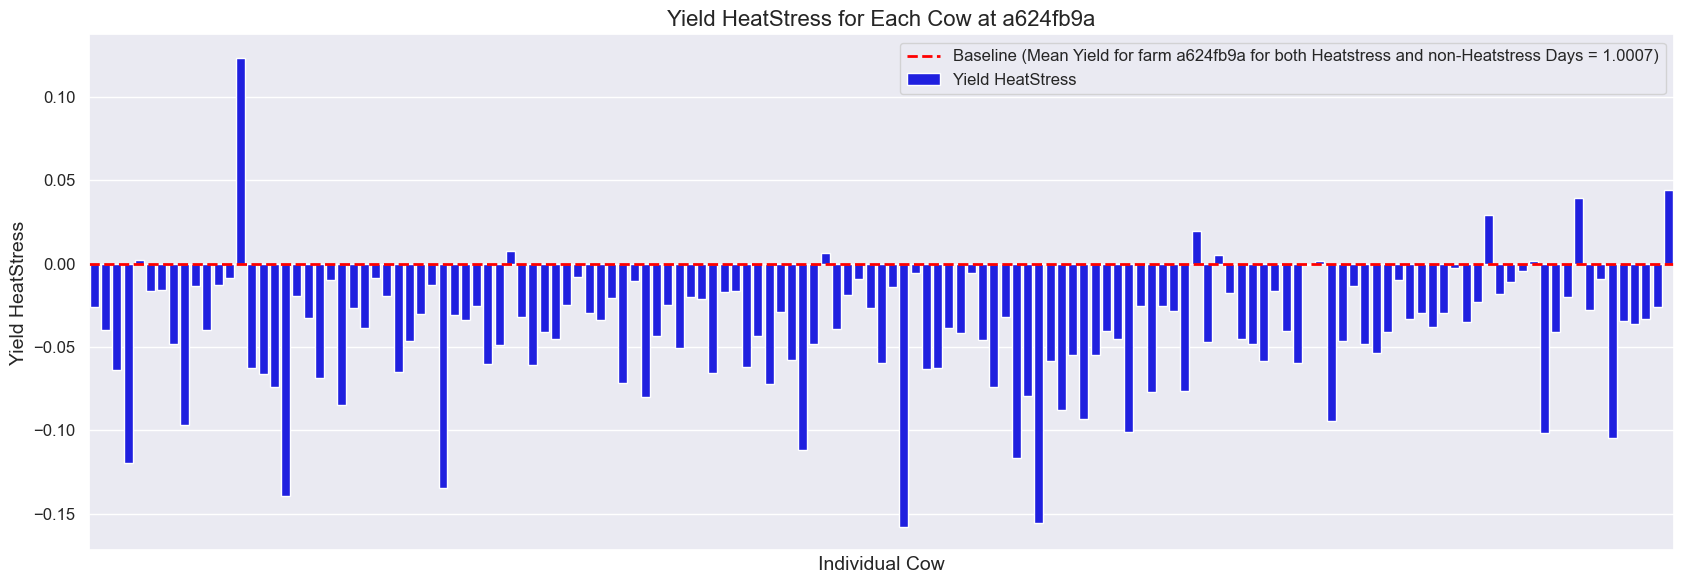

In [4]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

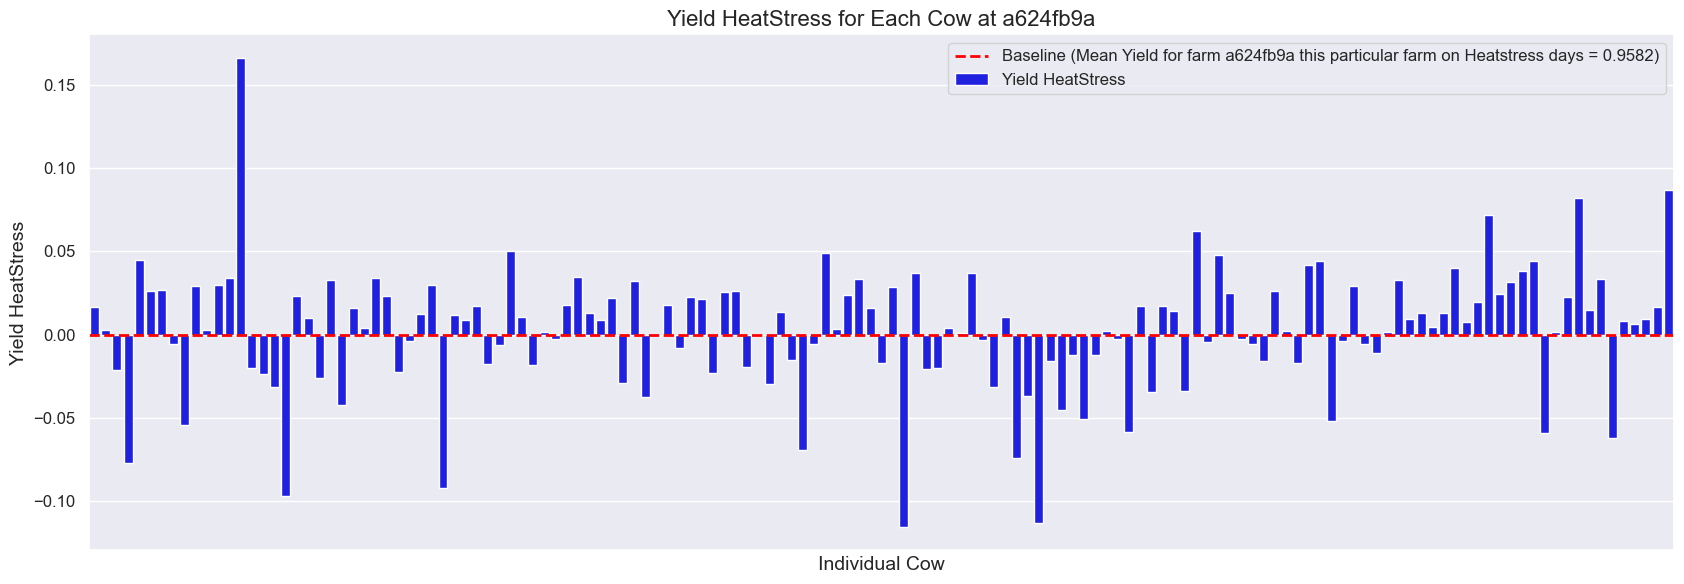

In [5]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for farm {farm} this particular farm on Heatstress days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


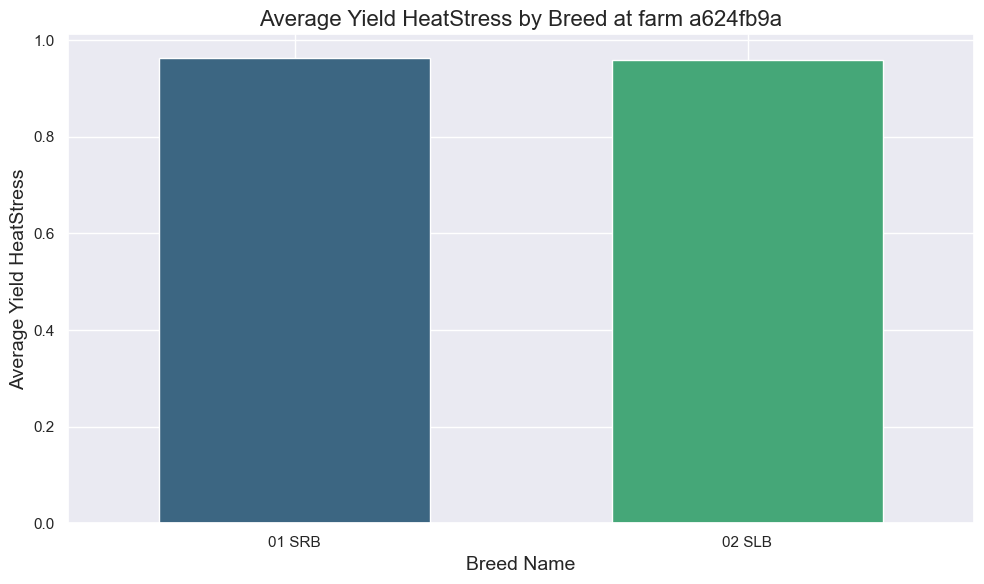

In [6]:
# Calculate the average Yield HeatStress per BreedName
average_heatstress_by_breed = results_df.groupby('BreedName')['Yield HeatStress'].mean().reset_index()

# Sort the results for better visualization
average_heatstress_by_breed = average_heatstress_by_breed.sort_values(by='Yield HeatStress', ascending=False)

# Plotting with different colors for each breed, without a legend
plt.figure(figsize=(10, 6))
sns.barplot(x='BreedName', y='Yield HeatStress', data=average_heatstress_by_breed, hue='BreedName', palette='viridis', width=0.6, dodge=False)

# Remove the legend
plt.legend().remove()

# Formatting the plot
plt.ylabel('Average Yield HeatStress', fontsize=14)
plt.xlabel('Breed Name', fontsize=14)
plt.title(f'Average Yield HeatStress by Breed at farm {farm}', fontsize=16)
plt.grid(True)
plt.tight_layout()

plt.show()

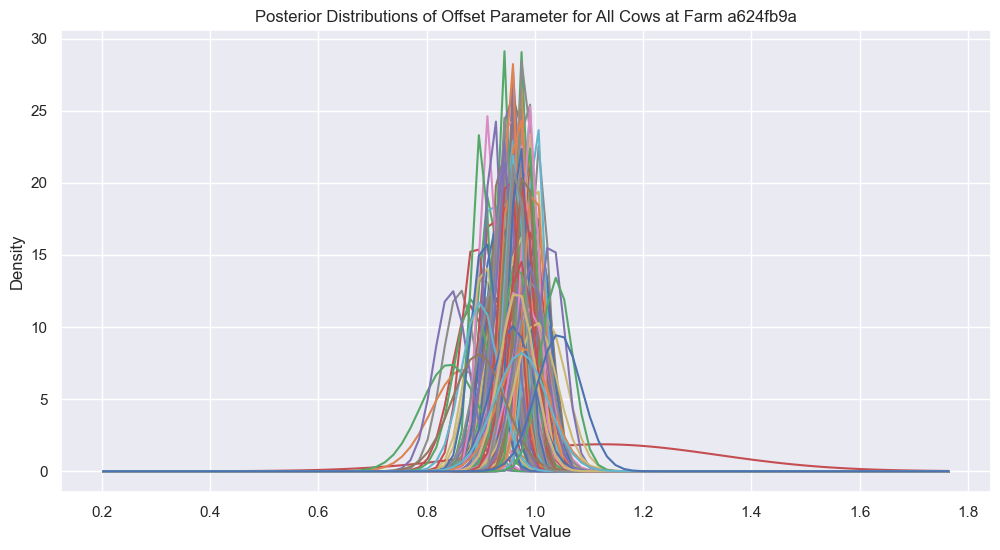

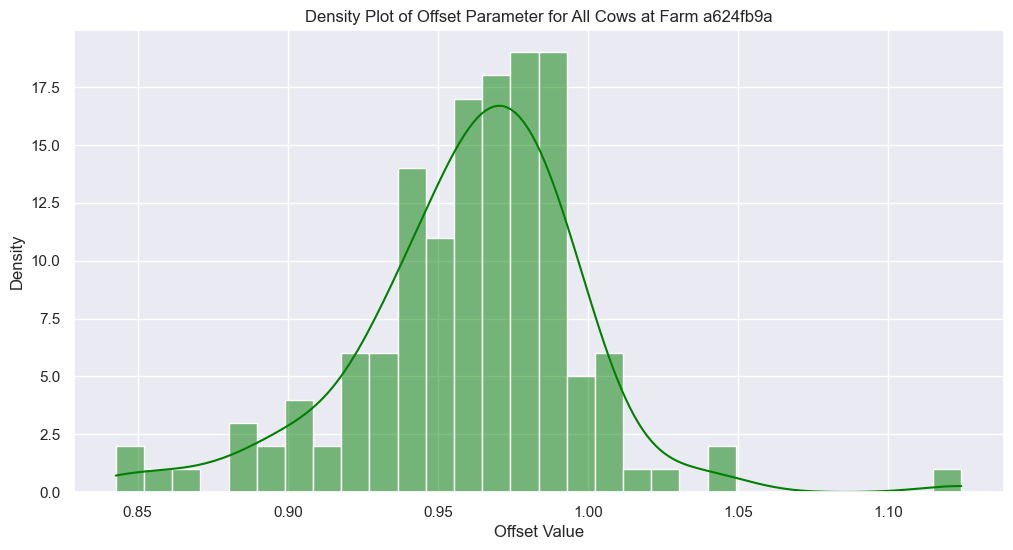

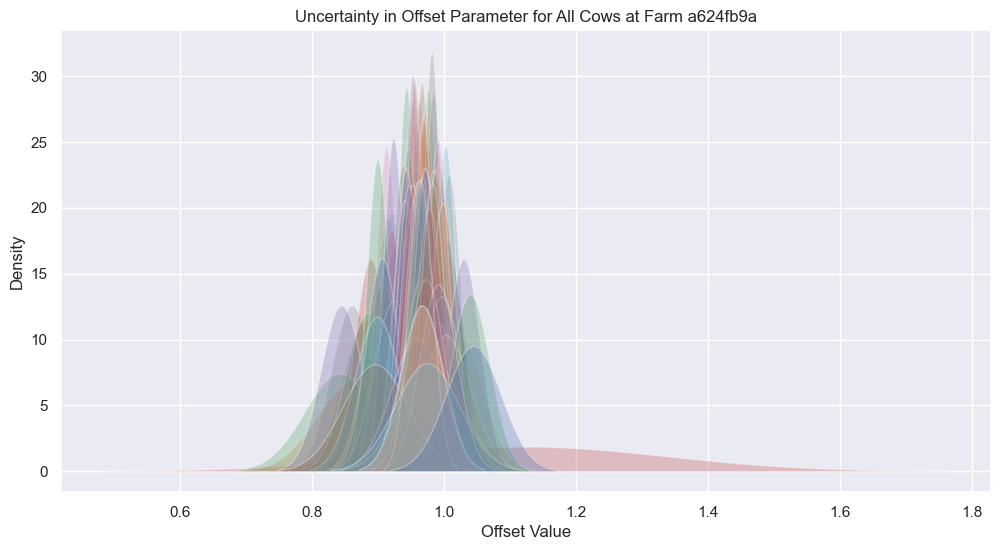

In [7]:
# Initialize lists to store aggregated data
offset_mus = []
offset_sigmas = []

# Extract offset parameters from each model
for model in models:
    offset_mu = model.posterior.mean[0][0]
    offset_sigma = np.sqrt(model.posterior.cov[0, 0])
    offset_mus.append(offset_mu)
    offset_sigmas.append(offset_sigma)

# Posterior Distribution Plot for all cows
plt.figure(figsize=(12, 6))
xx = np.linspace(min(offset_mus) - 3 * max(offset_sigmas), max(offset_mus) + 3 * max(offset_sigmas), 100)
for mu, sigma in zip(offset_mus, offset_sigmas):
    sns.lineplot(x=xx, y=stats.norm.pdf(xx, mu, sigma))
plt.title(f'Posterior Distributions of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Density Plot for all offset parameter estimates
plt.figure(figsize=(12, 6))
sns.histplot(offset_mus, bins=30, kde=True, color='green')
plt.title(f'Density Plot of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Uncertainty Plot for all cows
plt.figure(figsize=(12, 6))
for mu, sigma in zip(offset_mus, offset_sigmas):
    xx = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    plt.fill_between(xx, stats.norm.pdf(xx, mu, sigma), alpha=0.3)
plt.title(f'Uncertainty in Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

## Farm 5c06d92d

In [8]:
# Filter data for a specific farm
farm = '5c06d92d'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the feature 'MeanTemperature' is float type
data_heatstress['MeanTemperature'] = data_heatstress['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
data_heatstress['MeanTemperature'] = scaler.fit_transform(data_heatstress[['MeanTemperature']])

# List to store model instances for each cow
models = []

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the model instance for later use
        models.append(model)
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Fit the model and calculate yield changes for all cows
yield_changes_heatstress = fit_model_and_calculate_yield_change(data_heatstress, selected_feature)

# Create results DataFrame
results_df = pd.DataFrame({
    'SE_Number': yield_changes_heatstress.keys(),
    'Yield HeatStress': yield_changes_heatstress.values()
})

# First, reduce daily_farm_data to unique SE_Number and BreedName pairs
unique_breed_data = daily_farm_data[['SE_Number', 'BreedName']].drop_duplicates()

# Then, merge with the results_df on SE_Number
results_df = results_df.merge(unique_breed_data, on='SE_Number', how='left')

# Display the merged DataFrame
results_df

,SE_Number,Yield HeatStress,BreedName
0,SE-5c06d92d-2055,0.855075,02 SLB
1,SE-5c06d92d-2058,0.847856,06 RB
2,SE-5c06d92d-2254,0.908882,02 SLB
3,SE-5c06d92d-2283,0.962938,02 SLB
4,SE-5c06d92d-2333,0.850930,02 SLB
...,...,...,...
472,SE-5c06d92d-3441,1.003927,02 SLB
473,SE-5c06d92d-3443,0.830860,02 SLB
474,SE-5c06d92d-3485,0.703907,02 SLB
475,SE-5c06d92d-3511,0.980661,02 SLB


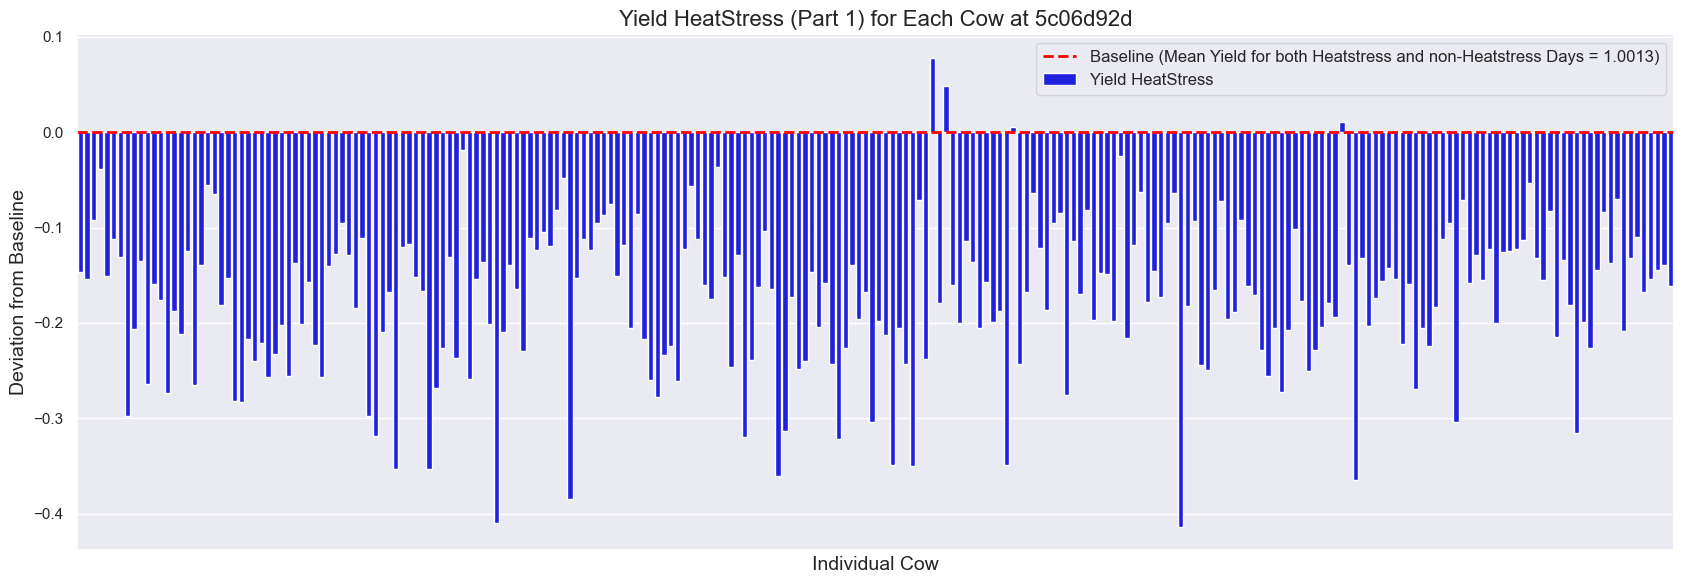

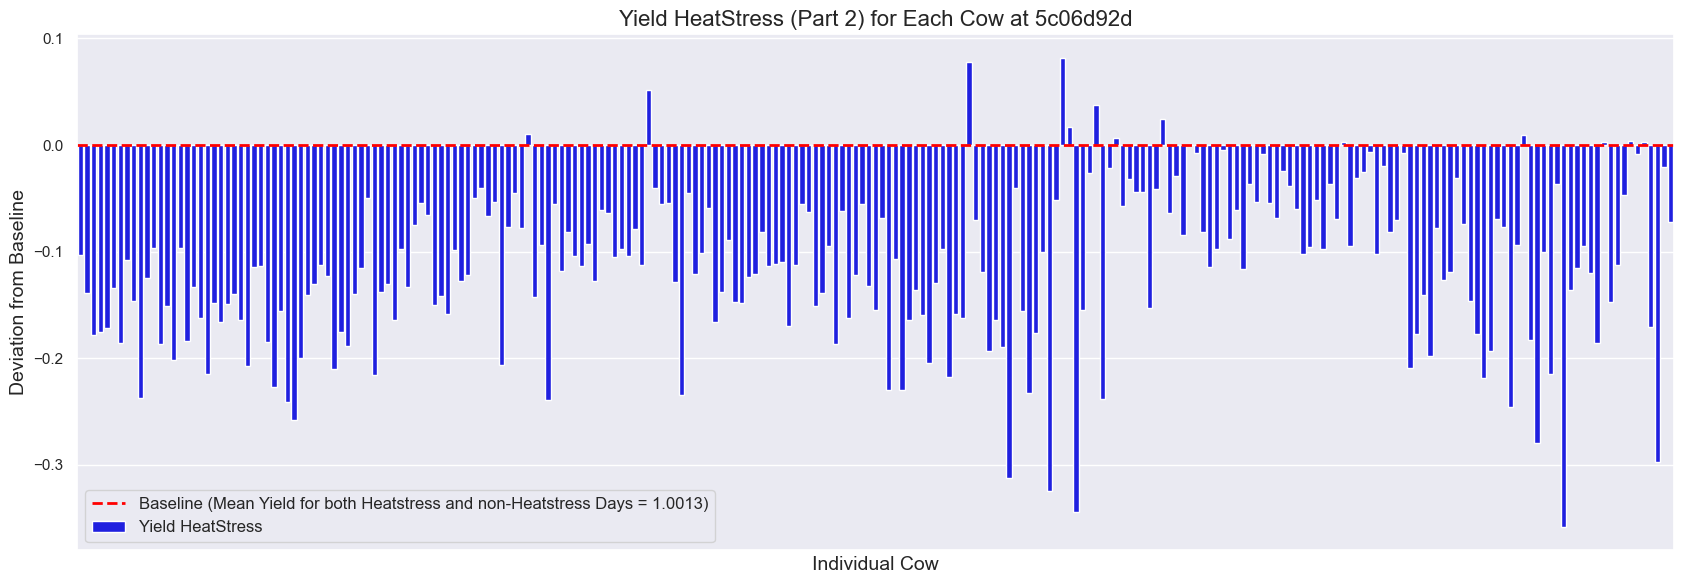

In [9]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

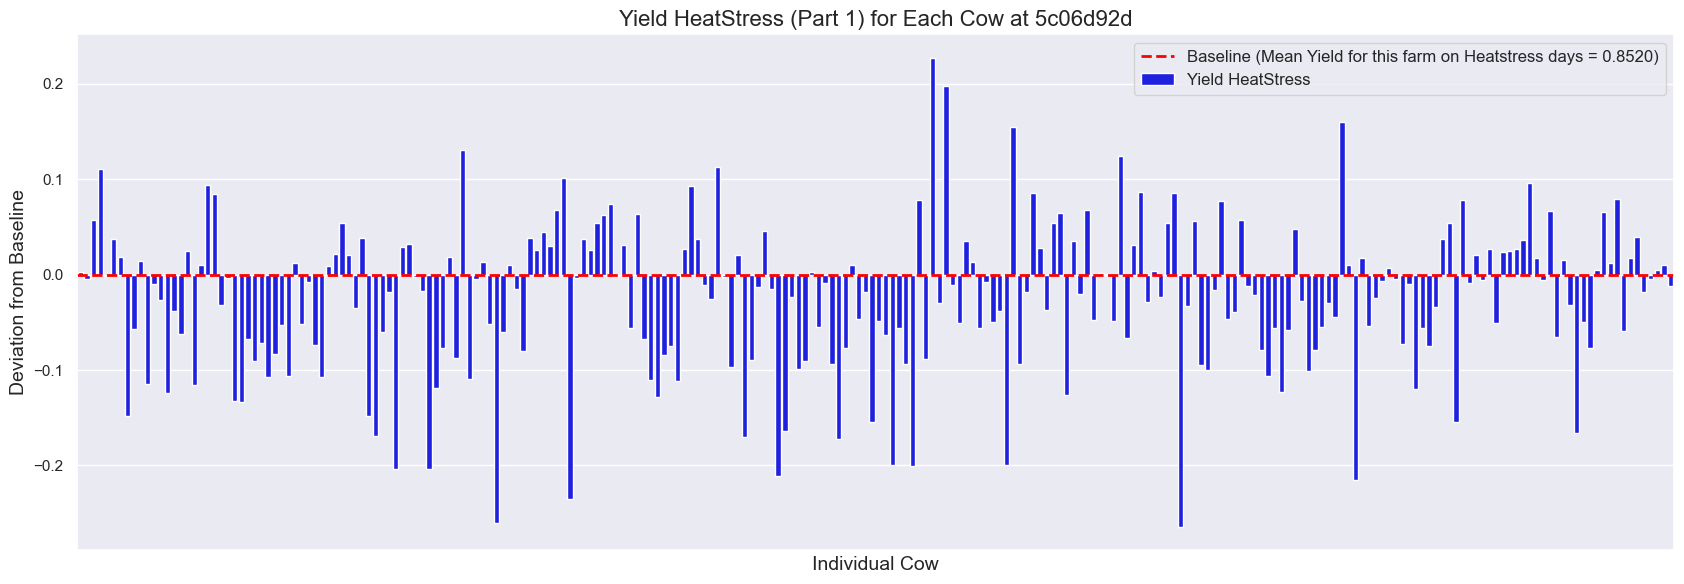

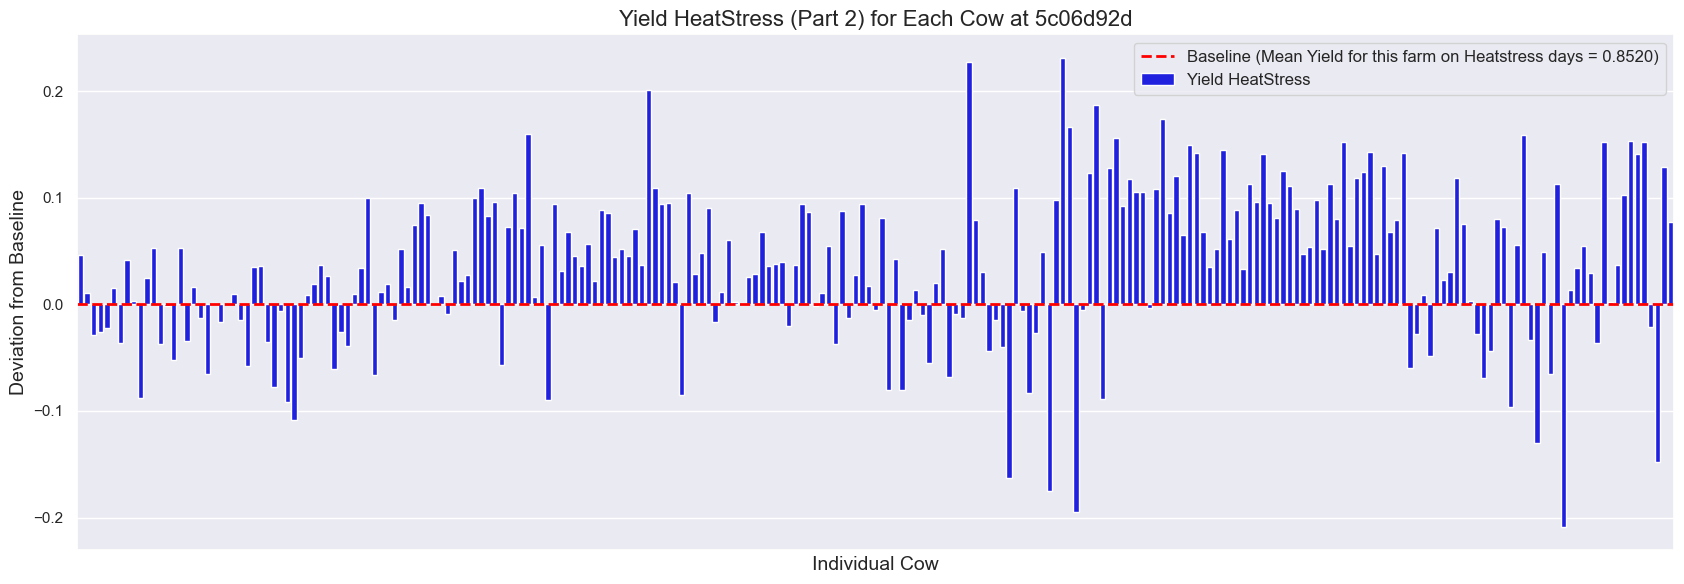

In [10]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


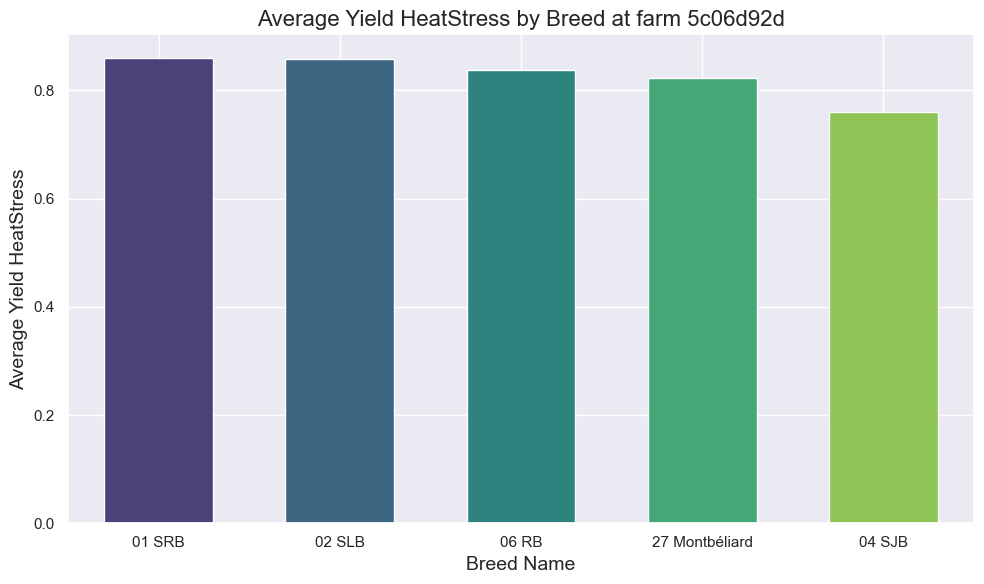

In [11]:
# Calculate the average Yield HeatStress per BreedName
average_heatstress_by_breed = results_df.groupby('BreedName')['Yield HeatStress'].mean().reset_index()

# Sort the results for better visualization
average_heatstress_by_breed = average_heatstress_by_breed.sort_values(by='Yield HeatStress', ascending=False)

# Plotting with different colors for each breed, without a legend
plt.figure(figsize=(10, 6))
sns.barplot(x='BreedName', y='Yield HeatStress', data=average_heatstress_by_breed, hue='BreedName', palette='viridis', width=0.6, dodge=False)

# Remove the legend
plt.legend().remove()

# Formatting the plot
plt.ylabel('Average Yield HeatStress', fontsize=14)
plt.xlabel('Breed Name', fontsize=14)
plt.title(f'Average Yield HeatStress by Breed at farm {farm}', fontsize=16)
plt.grid(True)
plt.tight_layout()

plt.show()

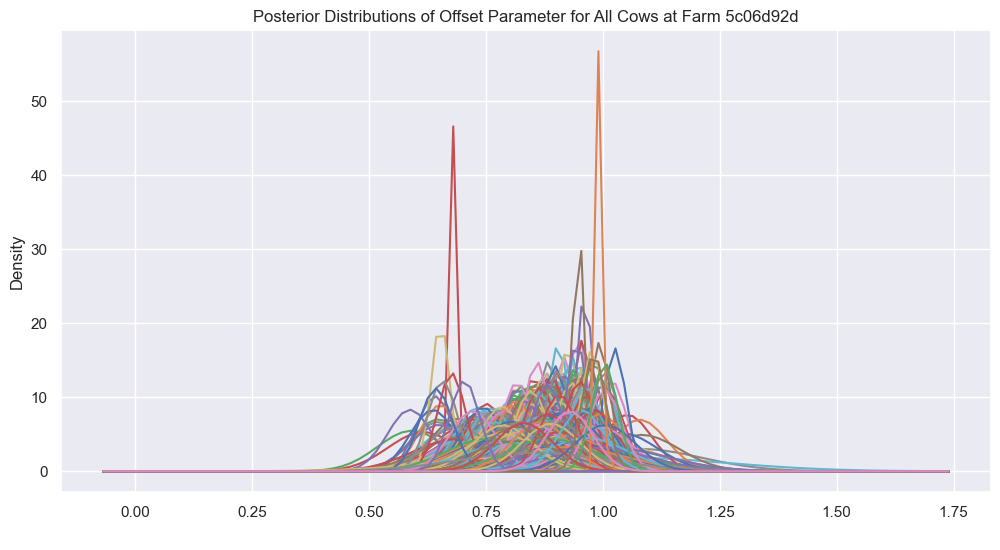

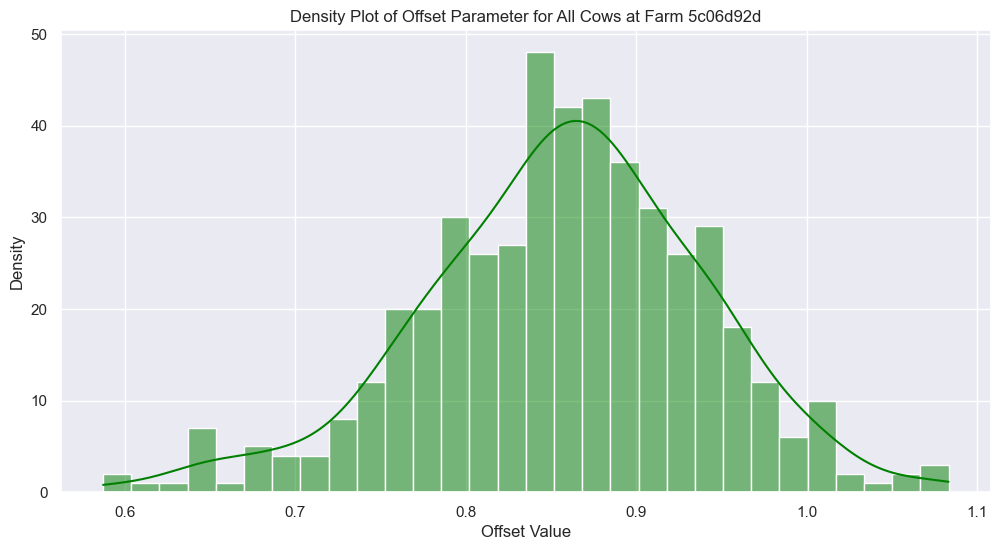

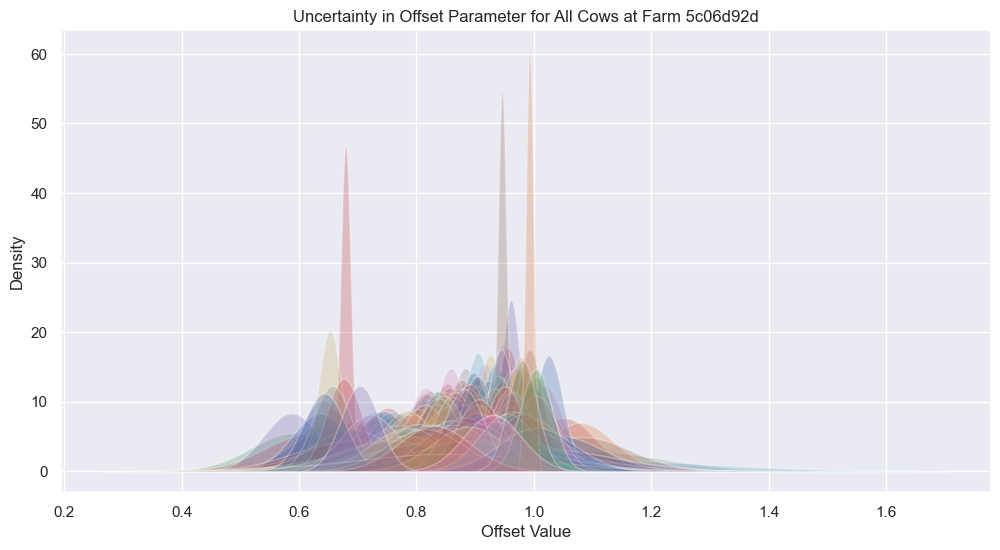

In [12]:
# Initialize lists to store aggregated data
offset_mus = []
offset_sigmas = []

# Extract offset parameters from each model
for model in models:
    offset_mu = model.posterior.mean[0][0]
    offset_sigma = np.sqrt(model.posterior.cov[0, 0])
    offset_mus.append(offset_mu)
    offset_sigmas.append(offset_sigma)

# Posterior Distribution Plot for all cows
plt.figure(figsize=(12, 6))
xx = np.linspace(min(offset_mus) - 3 * max(offset_sigmas), max(offset_mus) + 3 * max(offset_sigmas), 100)
for mu, sigma in zip(offset_mus, offset_sigmas):
    sns.lineplot(x=xx, y=stats.norm.pdf(xx, mu, sigma))
plt.title(f'Posterior Distributions of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Density Plot for all offset parameter estimates
plt.figure(figsize=(12, 6))
sns.histplot(offset_mus, bins=30, kde=True, color='green')
plt.title(f'Density Plot of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Uncertainty Plot for all cows
plt.figure(figsize=(12, 6))
for mu, sigma in zip(offset_mus, offset_sigmas):
    xx = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    plt.fill_between(xx, stats.norm.pdf(xx, mu, sigma), alpha=0.3)
plt.title(f'Uncertainty in Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

## Farm 752efd72

In [13]:
# Filter data for a specific farm
farm = '752efd72'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the feature 'MeanTemperature' is float type
data_heatstress['MeanTemperature'] = data_heatstress['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
data_heatstress['MeanTemperature'] = scaler.fit_transform(data_heatstress[['MeanTemperature']])

# List to store model instances for each cow
models = []

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the model instance for later use
        models.append(model)
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Fit the model and calculate yield changes for all cows
yield_changes_heatstress = fit_model_and_calculate_yield_change(data_heatstress, selected_feature)

# Create results DataFrame
results_df = pd.DataFrame({
    'SE_Number': yield_changes_heatstress.keys(),
    'Yield HeatStress': yield_changes_heatstress.values()
})

# First, reduce daily_farm_data to unique SE_Number and BreedName pairs
unique_breed_data = daily_farm_data[['SE_Number', 'BreedName']].drop_duplicates()

# Then, merge with the results_df on SE_Number
results_df = results_df.merge(unique_breed_data, on='SE_Number', how='left')

# Display the merged DataFrame
results_df

,SE_Number,Yield HeatStress,BreedName
0,SE-752efd72-0001,0.925620,Unknown Breed
1,SE-752efd72-0002,1.094571,02 SLB
2,SE-752efd72-0008,0.928120,02 SLB
3,SE-752efd72-0010,0.944894,02 SLB
4,SE-752efd72-0011,0.923290,02 SLB
...,...,...,...
397,SE-752efd72-0345,0.983463,02 SLB
398,SE-752efd72-0450,0.950003,02 SLB
399,SE-752efd72-0468,0.959095,02 SLB
400,SE-752efd72-0469,0.961461,02 SLB


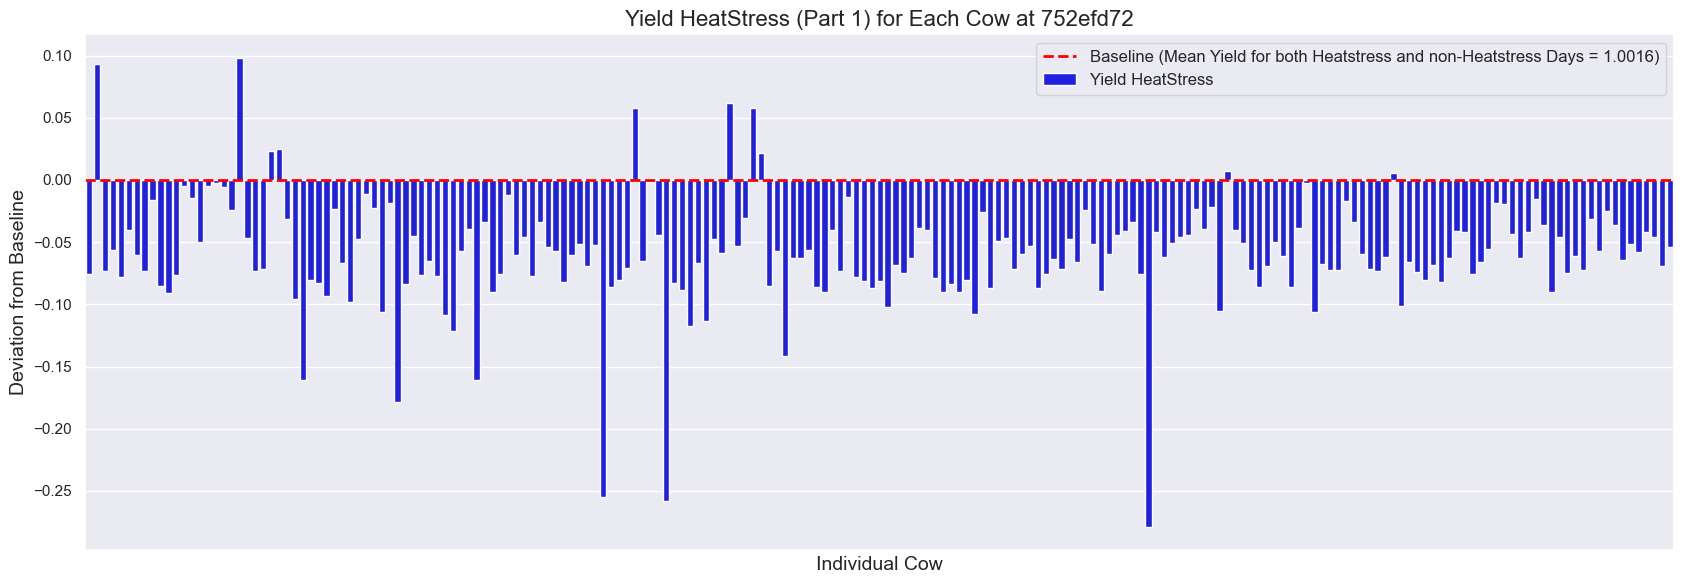

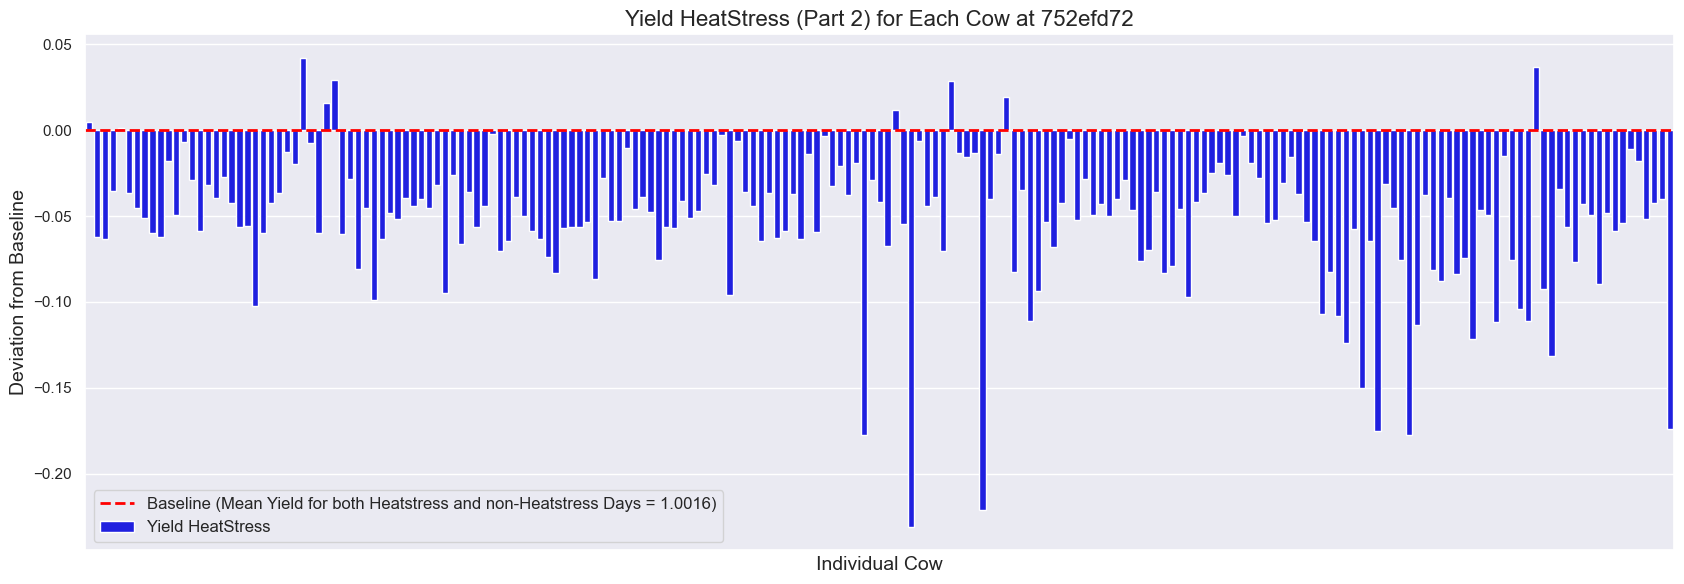

In [14]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

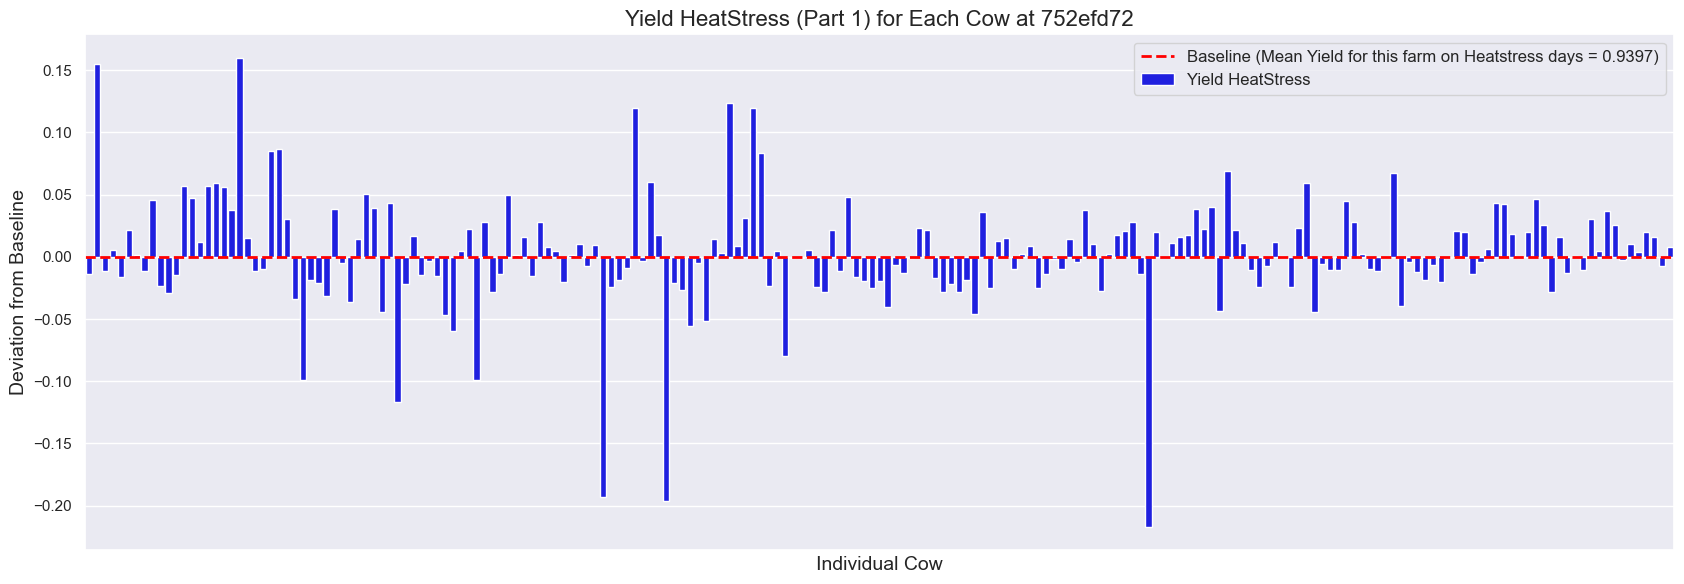

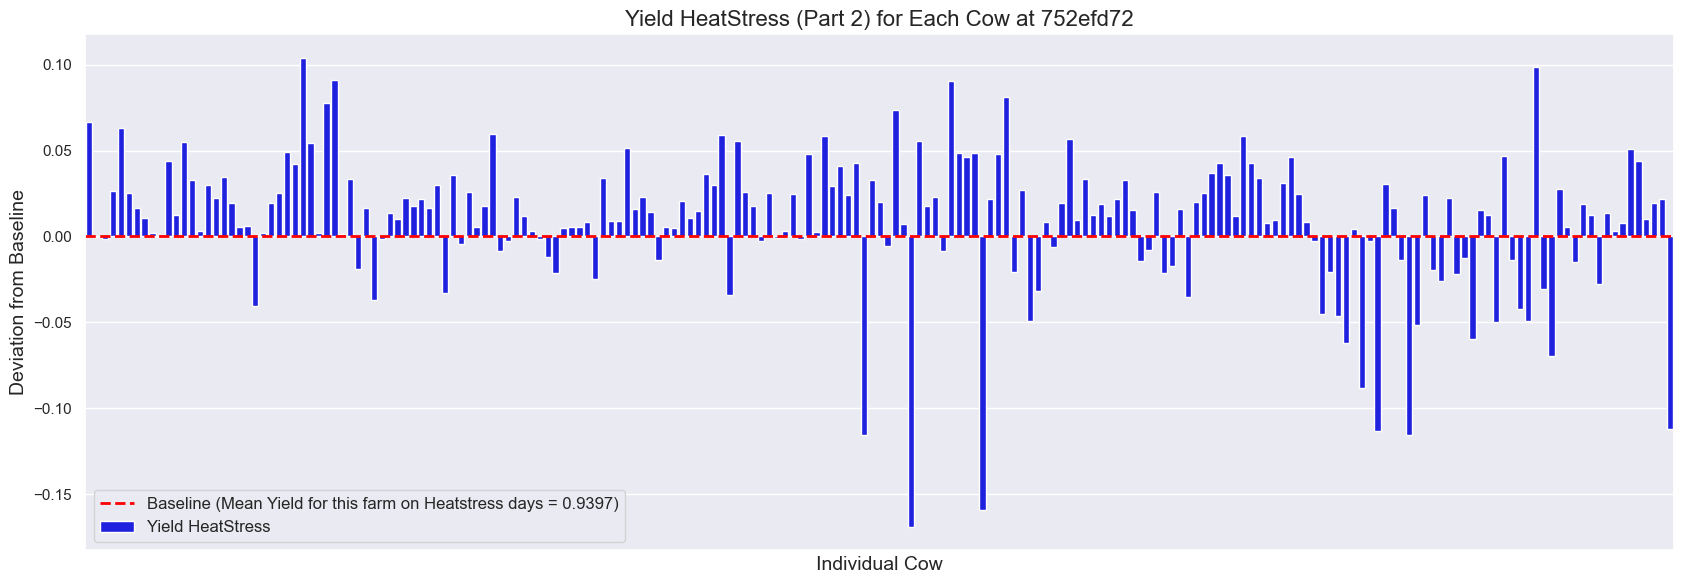

In [15]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Determine the midpoint to split the data
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 1) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['Deviation from Baseline'], color='blue', label='Yield HeatStress')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this farm on Heatstress days = {baseline_yield_change:.4f})')
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Deviation from Baseline', fontsize=14)
plt.title(f'Yield HeatStress (Part 2) for Each Cow at {farm}', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


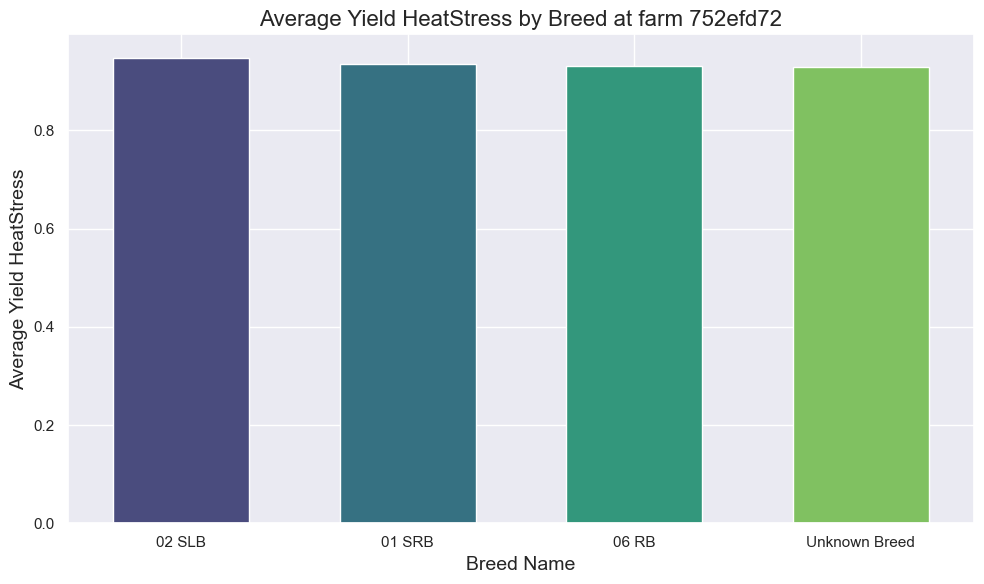

In [16]:
# Calculate the average Yield HeatStress per BreedName
average_heatstress_by_breed = results_df.groupby('BreedName')['Yield HeatStress'].mean().reset_index()

# Sort the results for better visualization
average_heatstress_by_breed = average_heatstress_by_breed.sort_values(by='Yield HeatStress', ascending=False)

# Plotting with different colors for each breed, without a legend
plt.figure(figsize=(10, 6))
sns.barplot(x='BreedName', y='Yield HeatStress', data=average_heatstress_by_breed, hue='BreedName', palette='viridis', width=0.6, dodge=False)

# Remove the legend
plt.legend().remove()

# Formatting the plot
plt.ylabel('Average Yield HeatStress', fontsize=14)
plt.xlabel('Breed Name', fontsize=14)
plt.title(f'Average Yield HeatStress by Breed at farm {farm}', fontsize=16)
plt.grid(True)
plt.tight_layout()

plt.show()

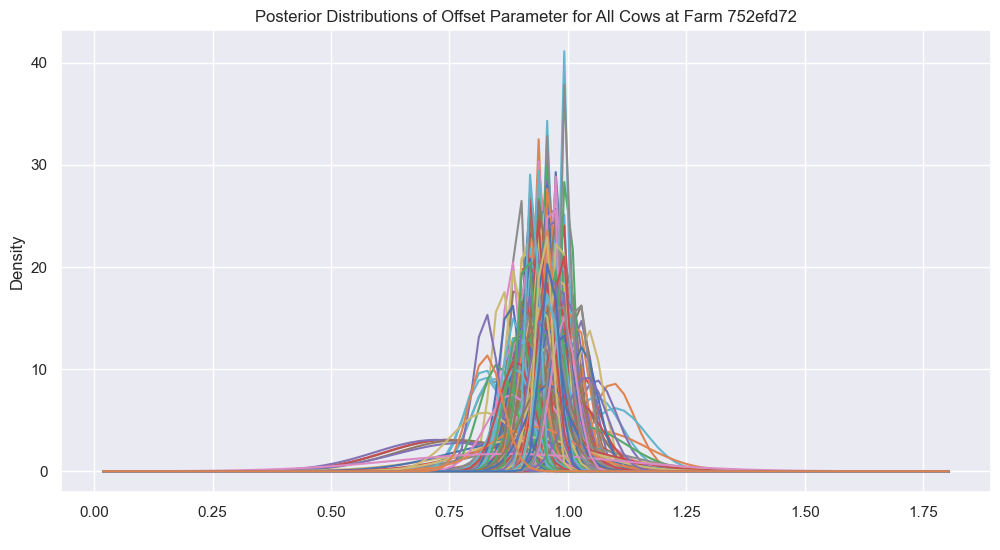

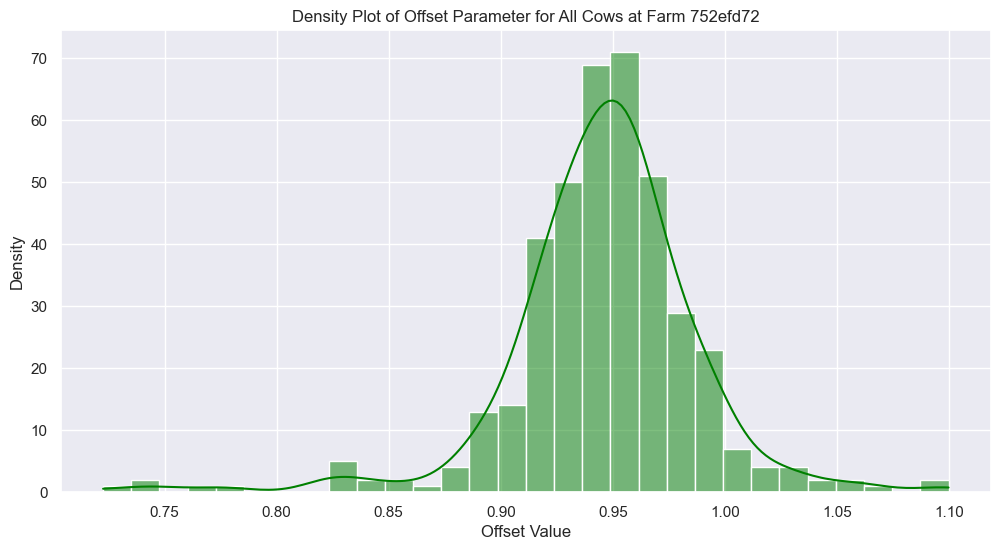

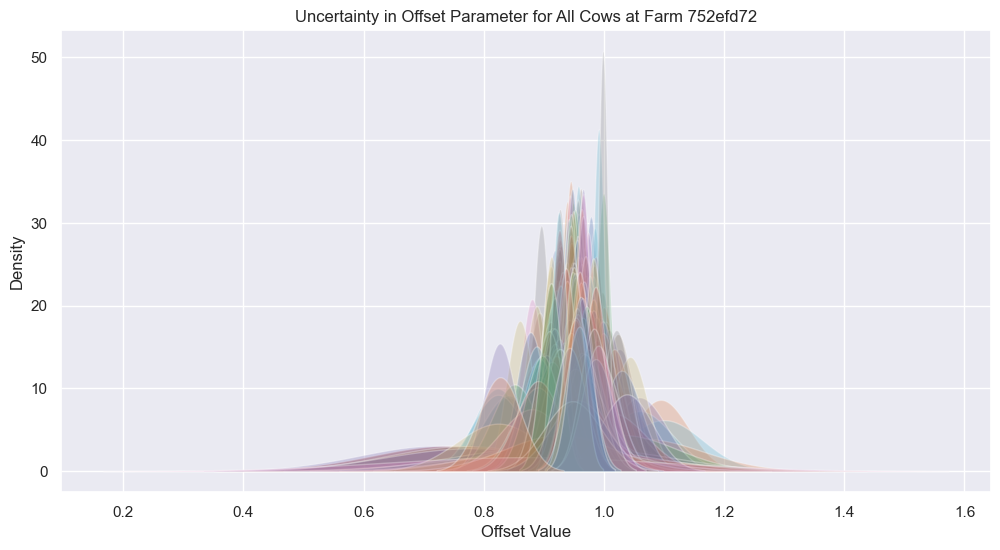

In [17]:
# Initialize lists to store aggregated data
offset_mus = []
offset_sigmas = []

# Extract offset parameters from each model
for model in models:
    offset_mu = model.posterior.mean[0][0]
    offset_sigma = np.sqrt(model.posterior.cov[0, 0])
    offset_mus.append(offset_mu)
    offset_sigmas.append(offset_sigma)

# Posterior Distribution Plot for all cows
plt.figure(figsize=(12, 6))
xx = np.linspace(min(offset_mus) - 3 * max(offset_sigmas), max(offset_mus) + 3 * max(offset_sigmas), 100)
for mu, sigma in zip(offset_mus, offset_sigmas):
    sns.lineplot(x=xx, y=stats.norm.pdf(xx, mu, sigma))
plt.title(f'Posterior Distributions of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Density Plot for all offset parameter estimates
plt.figure(figsize=(12, 6))
sns.histplot(offset_mus, bins=30, kde=True, color='green')
plt.title(f'Density Plot of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Uncertainty Plot for all cows
plt.figure(figsize=(12, 6))
for mu, sigma in zip(offset_mus, offset_sigmas):
    xx = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    plt.fill_between(xx, stats.norm.pdf(xx, mu, sigma), alpha=0.3)
plt.title(f'Uncertainty in Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

## Farm f454e660

In [18]:
# Filter data for a specific farm
farm = 'f454e660'
daily_farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm].copy()

# Filter data for HeatStress condition
data_heatstress = daily_farm_data[daily_farm_data['HeatStress'] == 1].copy()

# Ensure the feature 'MeanTemperature' is float type
data_heatstress['MeanTemperature'] = data_heatstress['MeanTemperature'].astype(float)

# Scale the 'MeanTemperature' feature
scaler = StandardScaler()
data_heatstress['MeanTemperature'] = scaler.fit_transform(data_heatstress[['MeanTemperature']])

# List to store model instances for each cow
models = []

# Function to fit model on entire dataset and calculate yield change for each cow
def fit_model_and_calculate_yield_change(data, feature):
    cow_ids = data['SE_Number'].unique()
    yield_changes = {}
    
    for cow in cow_ids:
        cow_data = data[data['SE_Number'] == cow]
        
        # Calculate cow's individual mean and variance for NormalizedDailyYield
        cow_mean = cow_data['NormalizedDailyYield'].mean()
        cow_variance = cow_data['NormalizedDailyYield'].var()
        if cow_variance < 1e-6:
            cow_variance = 1e-6  # Set a minimum threshold to avoid division by zero
        beta = 1 / cow_variance

        # Calculate prior mean for the feature
        prior_mean_value = cow_data[feature].mean()
        
        # Define priors
        prior_mean = np.array([cow_mean, prior_mean_value]).reshape(-1, 1)
        prior_cov = np.eye(2) * 0.01  # Stronger regularization
        
        # Initialize and fit the model on the entire dataset with the selected feature
        model = BayesianLinearRegression(
            dataframe=cow_data,
            subject_name=cow,
            selected_features=[feature],
            target='NormalizedDailyYield',
            subject_type='cow',
            prior_mean=prior_mean,
            prior_cov=prior_cov,
            beta=beta
        )
        result = model.fit_model()
        
        # Store the model instance for later use
        models.append(model)
        
        # Store the yield change for the cow
        yield_changes[cow] = result['Off-set']['mu']
    
    return yield_changes

# Use only 'MeanTemperature' as the feature
selected_feature = 'MeanTemperature'

# Fit the model and calculate yield changes for all cows
yield_changes_heatstress = fit_model_and_calculate_yield_change(data_heatstress, selected_feature)

# Create results DataFrame
results_df = pd.DataFrame({
    'SE_Number': yield_changes_heatstress.keys(),
    'Yield HeatStress': yield_changes_heatstress.values()
})

# First, reduce daily_farm_data to unique SE_Number and BreedName pairs
unique_breed_data = daily_farm_data[['SE_Number', 'BreedName']].drop_duplicates()

# Then, merge with the results_df on SE_Number
results_df = results_df.merge(unique_breed_data, on='SE_Number', how='left')

# Display the merged DataFrame
results_df

,SE_Number,Yield HeatStress,BreedName
0,SE-a2bab923-5680-5,0.916917,04 SJB
1,SE-f454e660-0139,0.973908,04 SJB
2,SE-f454e660-0335,0.956781,01 SRB
3,SE-f454e660-0412,1.010370,99 Korsning/obestämbar ras
4,SE-f454e660-0465,0.897128,41 Fjällko
...,...,...,...
184,SE-f454e660-747,0.953424,99 Korsning/obestämbar ras
185,SE-f454e660-750,0.986030,02 SLB
186,SE-f454e660-787,0.998757,99 Korsning/obestämbar ras
187,SE-f454e660-799,1.082047,02 SLB


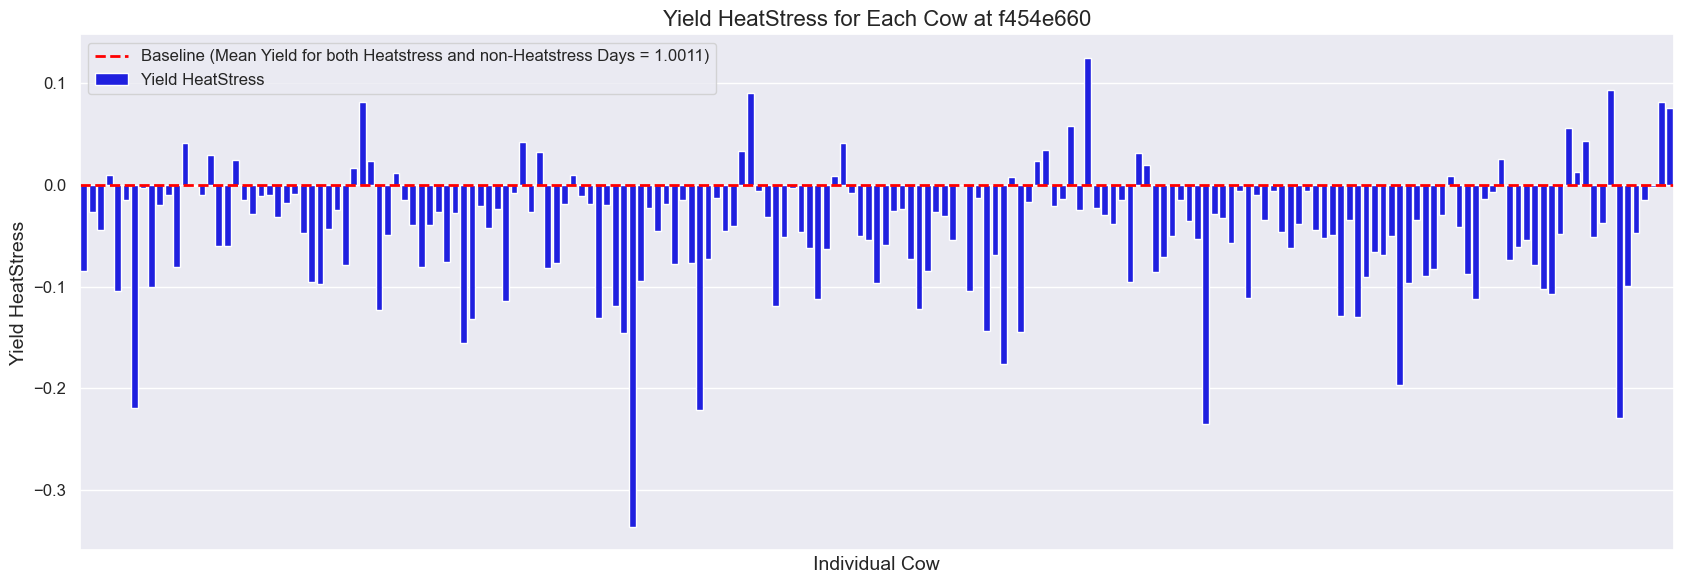

In [19]:
# Calculate the baseline
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for both Heatstress and non-Heatstress Days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

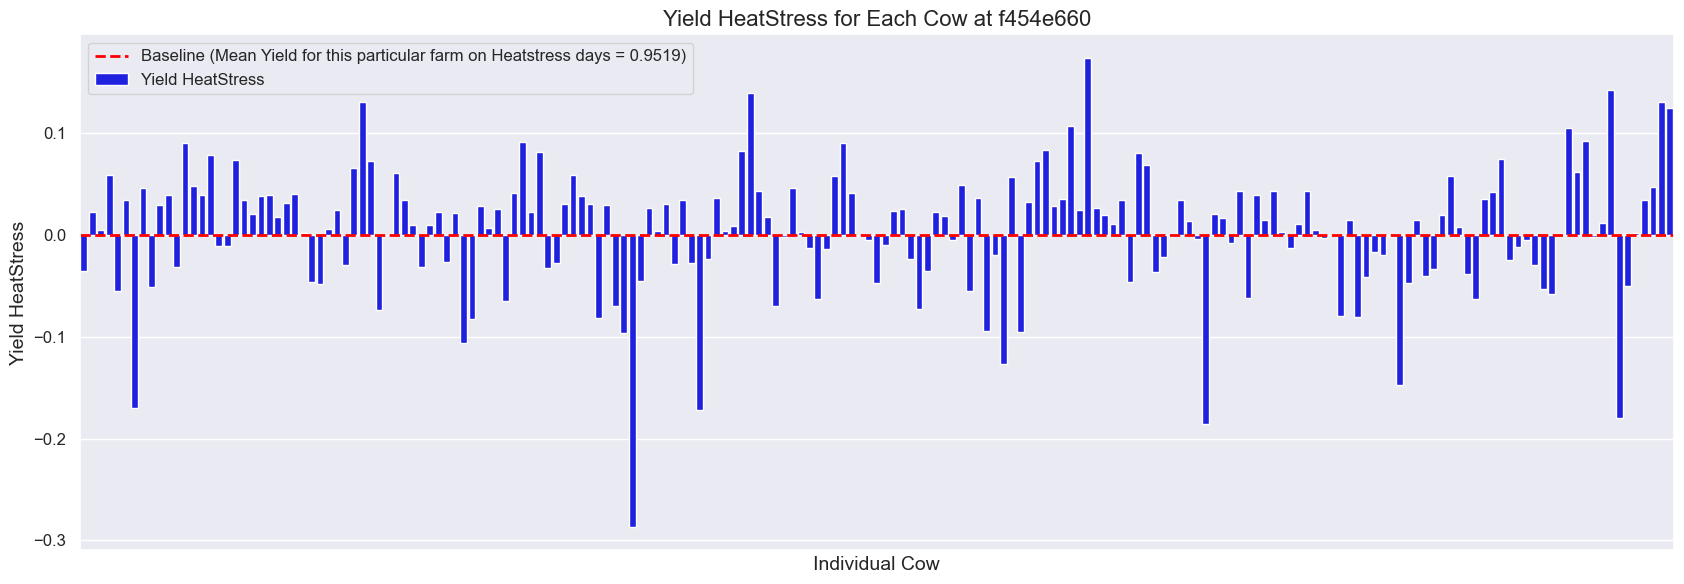

In [20]:
# Calculate the baseline (mean yield change)
baseline_yield_change = daily_farm_data['NormalizedDailyYield'].mean() + data_heatstress['FarmHeatStressMilkProduction'].mean()

# Calculate deviations from the baseline
results_df['Deviation from Baseline'] = results_df['Yield HeatStress'] - baseline_yield_change

# Plotting
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['Deviation from Baseline'], color='blue', label='Yield HeatStress')

# Add baseline line
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline (Mean Yield for this particular farm on Heatstress days = {baseline_yield_change:.4f})')

# Formatting the plot
plt.xlabel('Individual Cow', fontsize=14)
plt.ylabel('Yield HeatStress', fontsize=14)
plt.title(f'Yield HeatStress for Each Cow at {farm}', fontsize=16)


plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


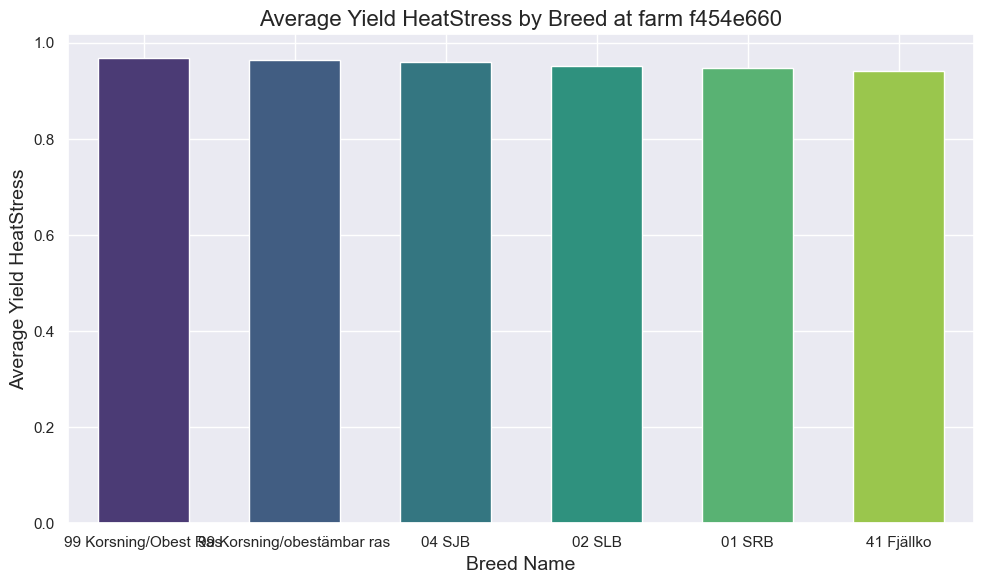

In [21]:
# Calculate the average Yield HeatStress per BreedName
average_heatstress_by_breed = results_df.groupby('BreedName')['Yield HeatStress'].mean().reset_index()

# Sort the results for better visualization
average_heatstress_by_breed = average_heatstress_by_breed.sort_values(by='Yield HeatStress', ascending=False)

# Plotting with different colors for each breed, without a legend
plt.figure(figsize=(10, 6))
sns.barplot(x='BreedName', y='Yield HeatStress', data=average_heatstress_by_breed, hue='BreedName', palette='viridis', width=0.6, dodge=False)

# Remove the legend
plt.legend().remove()

# Formatting the plot
plt.ylabel('Average Yield HeatStress', fontsize=14)
plt.xlabel('Breed Name', fontsize=14)
plt.title(f'Average Yield HeatStress by Breed at farm {farm}', fontsize=16)
plt.grid(True)
plt.tight_layout()

plt.show()

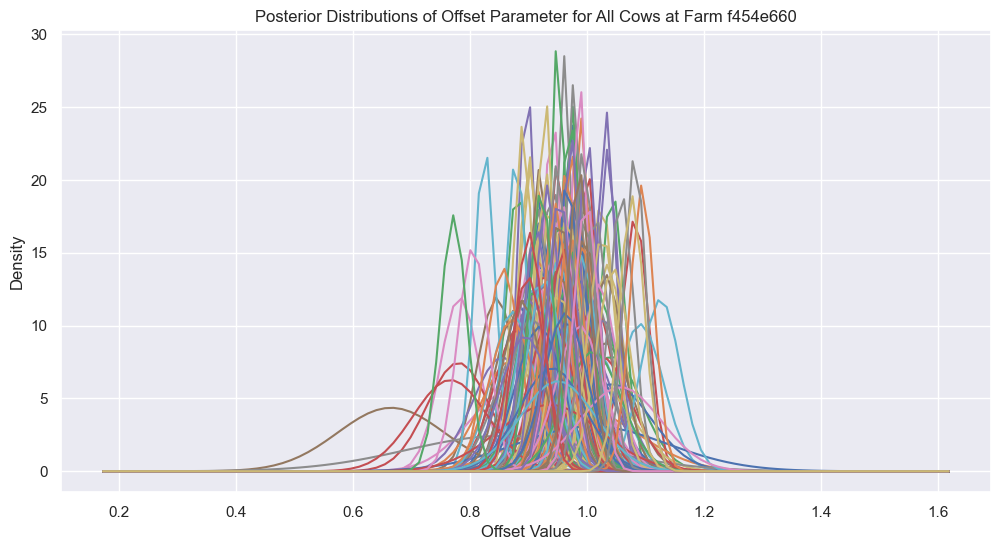

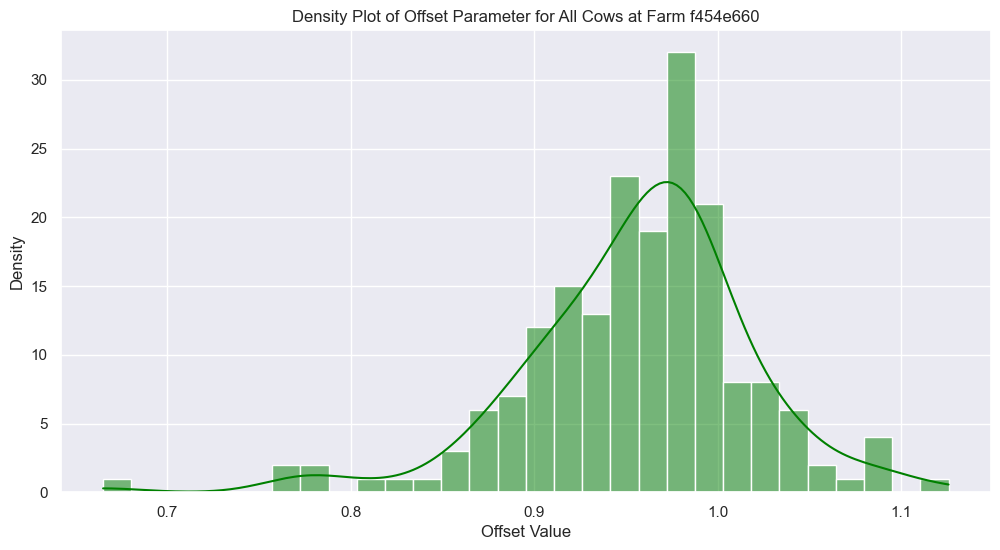

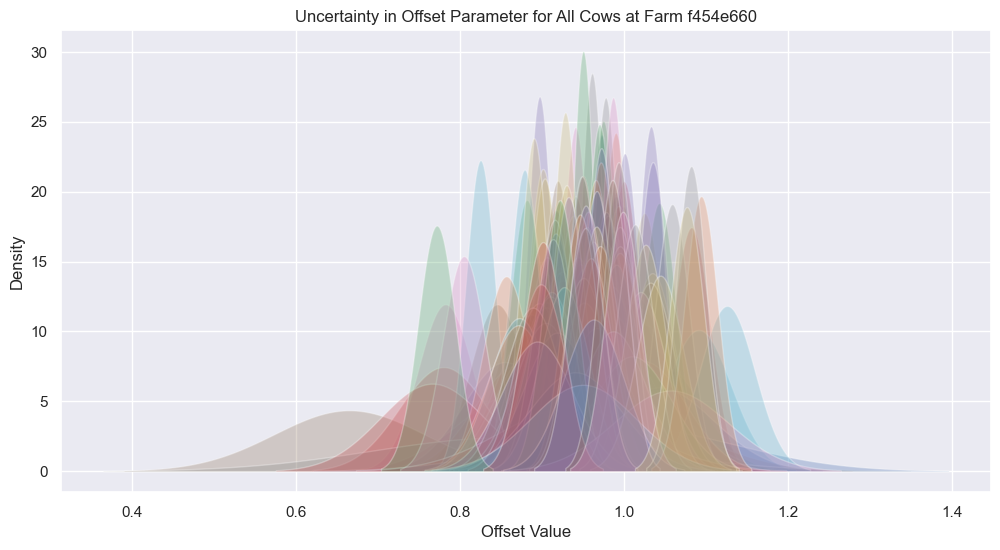

In [22]:
# Initialize lists to store aggregated data
offset_mus = []
offset_sigmas = []

# Extract offset parameters from each model
for model in models:
    offset_mu = model.posterior.mean[0][0]
    offset_sigma = np.sqrt(model.posterior.cov[0, 0])
    offset_mus.append(offset_mu)
    offset_sigmas.append(offset_sigma)

# Posterior Distribution Plot for all cows
plt.figure(figsize=(12, 6))
xx = np.linspace(min(offset_mus) - 3 * max(offset_sigmas), max(offset_mus) + 3 * max(offset_sigmas), 100)
for mu, sigma in zip(offset_mus, offset_sigmas):
    sns.lineplot(x=xx, y=stats.norm.pdf(xx, mu, sigma))
plt.title(f'Posterior Distributions of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Density Plot for all offset parameter estimates
plt.figure(figsize=(12, 6))
sns.histplot(offset_mus, bins=30, kde=True, color='green')
plt.title(f'Density Plot of Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Uncertainty Plot for all cows
plt.figure(figsize=(12, 6))
for mu, sigma in zip(offset_mus, offset_sigmas):
    xx = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
    plt.fill_between(xx, stats.norm.pdf(xx, mu, sigma), alpha=0.3)
plt.title(f'Uncertainty in Offset Parameter for All Cows at Farm {farm}')
plt.xlabel('Offset Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()